In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import h5py
import copy
import tqdm
from sklearn.model_selection import KFold
import random

# MiRNA Sequence

## K-mer

Not used in our method ultimately...

In [51]:
mirnas = pd.read_table('our_data/nodes/mirnas.tsv')
mirnas.head(3)

,Accession,ID,Sequence,Mature1_Acc,Mature1_ID,Mature1_Seq,Mature2_Acc,Mature2_ID,Mature2_Seq
0,MI0000060,hsa-let-7a-1,UGGGAUGAGGUAGUAGGUUGUAUAGUUUUAGGGUCACACCCACCAC...,MIMAT0000062,hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU,MIMAT0004481,hsa-let-7a-3p,CUAUACAAUCUACUGUCUUUC
1,MI0000061,hsa-let-7a-2,AGGUUGAGGUAGUAGGUUGUAUAGUUUAGAAUUACAUCAAGGGAGA...,MIMAT0000062,hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU,MIMAT0010195,hsa-let-7a-2-3p,CUGUACAGCCUCCUAGCUUUCC
2,MI0000062,hsa-let-7a-3,GGGUGAGGUAGUAGGUUGUAUAGUUUGGGGCUCUGCCCUGCUAUGG...,MIMAT0000062,hsa-let-7a-5p,UGAGGUAGUAGGUUGUAUAGUU,MIMAT0004481,hsa-let-7a-3p,CUAUACAAUCUACUGUCUUUC


In [52]:
print(mirnas['Sequence'].str.len().max(), mirnas['Mature1_Seq'].str.len().max(), mirnas['Mature2_Seq'].str.len().max())

180 27 28.0


In [53]:
def get_kmer(seq, k, max_len):
    seq = seq + 'N' * (max_len - len(seq))
    sub_seqs = [seq[i: i + k] for i in range(len(seq) - k + 1)]
    kmer_onehot_seqs = []
    AUCG_map = {
        'A': 0,
        'U': 1,
        'C': 2,
        'G': 3
    } # A, U, C, G -> 0, 1, 2, 3
    for sub_seq in sub_seqs:
        kmer_onehot_seq = np.zeros(pow(4, k) + 1)
        if 'N' in sub_seq:
            kmer_onehot_seq[-1] = 1
        else:
            num = 0
            for i in range(k):
                num = num + AUCG_map[sub_seq[k - 1 - i]] * pow(4, i)
            kmer_onehot_seq[num] = 1
        kmer_onehot_seqs.append(kmer_onehot_seq)
    return np.array(kmer_onehot_seqs)

In [54]:
get_kmer('', 2, 3)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.]])

In [55]:
get_kmer('AUUGGC', 2, 8)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.]])

In [56]:
def save_kmer(k, pri_max_len, mature1_max_len, mature2_max_len):
    path = 'our_data/nodes/mirnas_' + str(k) + '.h5'
    f = h5py.File(path, 'w')
    for index, mirna in mirnas.iterrows():
        dg = f.create_group(mirna['Accession'])
        dg.create_dataset('pri_seq', data=get_kmer(mirna['Sequence'], k, pri_max_len))
        dg.create_dataset('mature1_seq', data=get_kmer(mirna['Mature1_Seq'], k, mature1_max_len))
        if not pd.isna(mirna['Mature2_Acc']):
            dg.create_dataset('mature2_seq', data=get_kmer(mirna['Mature2_Seq'], k, mature2_max_len))
        else:
            dg.create_dataset('mature2_seq', data=get_kmer('', k, mature2_max_len))
    f.close()

In [57]:
# save_kmer(3, 180, 27, 28)

In [ ]:
# f = h5py.File('our_data/nodes/mirnas_3.h5',"r")
# f.visititems(print)
# f.close()

## 1-mer  

It's what we use.

In [59]:
def get_1mer(seq, max_len):
    seq = seq + 'N' * (max_len - len(seq))
    onehot_seqs = []
    AUCG_map = {
        'A': 0,
        'U': 1,
        'C': 2,
        'G': 3
    } # A, U, C, G -> 0, 1, 2, 3
    for i in range(len(seq)):
        if seq[i] == 'N':
            onehot_seqs.append(np.array([0.25, 0.25, 0.25, 0.25]))
        else:
            onehot_seq = np.zeros(4)
            onehot_seq[AUCG_map[seq[i]]] = 1
            onehot_seqs.append(onehot_seq)
    return np.array(onehot_seqs)

In [60]:
get_1mer('AUUGGC', 8)

array([[1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [61]:
def save_1mer(pri_max_len, mature1_max_len, mature2_max_len):
    path = 'our_data/nodes/mirnas_1.h5'
    f = h5py.File(path, 'w')
    for index, mirna in mirnas.iterrows():
        dg = f.create_group(mirna['Accession'])
        dg.create_dataset('pri_seq', data=get_1mer(mirna['Sequence'], pri_max_len))
        dg.create_dataset('mature1_seq', data=get_1mer(mirna['Mature1_Seq'], mature1_max_len))
        if not pd.isna(mirna['Mature2_Acc']):
            dg.create_dataset('mature2_seq', data=get_1mer(mirna['Mature2_Seq'], mature2_max_len))
        else:
            dg.create_dataset('mature2_seq', data=get_1mer('', mature2_max_len))
    f.close()

In [62]:
save_1mer(180, 27, 28)

In [ ]:
f = h5py.File('our_data/nodes/mirnas_1.h5',"r")
f.visititems(print)
f.close()

# Disease Text

## BioBERT

In [65]:
diseases = pd.read_table('our_data/nodes/diseases.tsv')
diseases.head(3)

,ID,Disease Name,MeSH Scope Note
0,D000006,"Abdomen, Acute",A clinical syndrome with acute abdominal pain ...
1,D000007,Abdominal Injuries,General or unspecified injuries involving orga...
2,D000008,Abdominal Neoplasms,New abnormal growth of tissue in the ABDOMEN.


The following txt and h5 files are then moved to **'our_data/nodes'**.

In [25]:
diseases['Disease Name'].to_csv('biobert-pytorch/embedding/mesh_disease_name.txt', sep = '\t', index=False)

In [41]:
diseases['MeSH Scope Note'].str.replace('"', '').to_csv('biobert-pytorch/embedding/mesh_disease_scope_note.txt', sep = '\t', index=False)

Run the following command under 'biobert-pytorch/embedding'

**mesh_disease_name**
```bash
export MAX_LENGTH=384
export DATA_PATH=mesh_disease_name.txt
export OUTPUT_PATH=mesh_disease_name.h5
export BATCH_SIZE=64

python run_embedding.py \
    --model_name_or_path dmis-lab/biobert-base-cased-v1.1 \
    --max_seq_length  ${MAX_LENGTH} \
    --data_path ${DATA_PATH} \
    --output_path ${OUTPUT_PATH} \
    --batch_size ${BATCH_SIZE} \
    --pooling mean
```
**mesh_disease_scope_note**
```bash
export MAX_LENGTH=384
export DATA_PATH=mesh_disease_scope_note.txt
export OUTPUT_PATH=mesh_disease_scope_note.h5
export BATCH_SIZE=64

python run_embedding.py \
    --model_name_or_path dmis-lab/biobert-base-cased-v1.1 \
    --max_seq_length  ${MAX_LENGTH} \
    --data_path ${DATA_PATH} \
    --output_path ${OUTPUT_PATH} \
    --batch_size ${BATCH_SIZE} \
    --pooling mean
```

In [ ]:
f = h5py.File('biobert-pytorch/embedding/mesh_disease_name.h5', 'r')
f.visititems(print)
f.close()

In [ ]:
f = h5py.File('biobert-pytorch/embedding/mesh_disease_scope_note.h5', 'r')
f.visititems(print)
f.close()

diseases.tsv & mesh_disease_name.h5 & mesh_disease_scope_note.h5 -> diseases.h5

In [ ]:
f_name = h5py.File('our_data/nodes/mesh_disease_name.h5', 'r')
f_name.visititems(print)

In [ ]:
f_note = h5py.File('our_data/nodes/mesh_disease_scope_note.h5', 'r')
f_note.visititems(print)

In [68]:
f = h5py.File('our_data/nodes/diseases.h5', 'w')

diseases['MeSH Scope Note'] = diseases['MeSH Scope Note'].str.replace('"', '')
for index, disease in diseases.iterrows():
    dg = f.create_group(disease['ID'])
    dg.create_dataset('disease_name', data=np.array(f_name[disease['Disease Name']]['embedding']))
    dg.create_dataset('mesh_scope_note', data=np.array(f_note[disease['MeSH Scope Note']]['embedding']))

f.close()

In [69]:
f_name.close()
f_note.close()

In [ ]:
f = h5py.File('our_data/nodes/diseases.h5', 'r')
f.visititems(print)
f.close()

# MRNA Name

## BioBERT

In [16]:
mrnas = pd.read_table('our_data/nodes/mrnas.tsv')
mrnas['Gene Groups'] = mrnas['Gene Groups'].fillna('Null')
mrnas.head(3)

,ID,Symbol,Name,Gene Groups
0,1,A1BG,alpha-1-B glycoprotein,Immunoglobulin like domain containing
1,29974,A1CF,APOBEC1 complementation factor,RNA binding motif containing
2,2,A2M,alpha-2-macroglobulin,Alpha-2-macroglobulin family


The following txt and h5 files are then moved to  **'our_data/nodes'**.

In [6]:
mrnas['Name'].to_csv('biobert-pytorch/embedding/mrna_name.txt', sep = '\t', index=False)

In [17]:
mrnas['Gene Groups'].drop_duplicates().to_csv('biobert-pytorch/embedding/mrna_gene_groups.txt', sep = '\t', index=False)

Run the following command under 'biobert-pytorch/embedding'

**mrna_name**
```bash
export MAX_LENGTH=384
export DATA_PATH=mrna_name.txt
export OUTPUT_PATH=mrna_name.h5
export BATCH_SIZE=64

python run_embedding.py \
    --model_name_or_path dmis-lab/biobert-base-cased-v1.1 \
    --max_seq_length  ${MAX_LENGTH} \
    --data_path ${DATA_PATH} \
    --output_path ${OUTPUT_PATH} \
    --batch_size ${BATCH_SIZE} \
    --pooling mean
```

**gene_groups**
```bash
export MAX_LENGTH=384
export DATA_PATH=mrna_gene_groups.txt
export OUTPUT_PATH=mrna_gene_groups.h5
export BATCH_SIZE=64

python run_embedding.py \
    --model_name_or_path dmis-lab/biobert-base-cased-v1.1 \
    --max_seq_length  ${MAX_LENGTH} \
    --data_path ${DATA_PATH} \
    --output_path ${OUTPUT_PATH} \
    --batch_size ${BATCH_SIZE} \
    --pooling mean
```

In [ ]:
f = h5py.File('biobert-pytorch/embedding/mrna_name.h5', 'r')
f.visititems(print)
f.close()

In [ ]:
f = h5py.File('biobert-pytorch/embedding/mrna_gene_groups.h5', 'r')
f.visititems(print)
f.close()

mrnas.tsv & mrna_name.h5 & mrna_gene_groups.h5 -> mrnas.h5

In [ ]:
f_name = h5py.File('our_data/nodes/mrna_name.h5', 'r')
f_name.visititems(print)

In [ ]:
f_group = h5py.File('our_data/nodes/mrna_gene_groups.h5', 'r')
f_group.visititems(print)

In [13]:
f = h5py.File('our_data/nodes/mrnas.h5', 'w')

mrnas['Gene Groups'] = mrnas['Gene Groups'].str.strip()

for index, mrna in mrnas.iterrows():
    dg = f.create_group(str(mrna['ID']))
    dg.create_dataset('mrna_name', data=np.array(f_name[mrna['Name']]['embedding']))
    dg.create_dataset('mrna_gene_groups', data=np.array(f_group[mrna['Gene Groups']]['embedding']))

f.close()

In [14]:
f_name.close()
f_group.close()

In [ ]:
f = h5py.File('our_data/nodes/mrnas.h5', 'r')
f.visititems(print)
f.close()

# Heterogeneous Graph (PyG)

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

## data_without_mrna_and_mid

In [3]:
mirnas_df = pd.read_table('our_data/nodes/mirnas.tsv')
assert len(mirnas_df['Accession']) == len(mirnas_df['Accession'].unique())

mirna_id = pd.DataFrame(data={
    'mirna_id': mirnas_df['Accession'],
    'mapped_id': pd.RangeIndex(len(mirnas_df['Accession']))
})

diseases_df = pd.read_table('our_data/nodes/diseases.tsv')
assert len(diseases_df['ID']) == len(diseases_df['ID'].unique())

disease_id = pd.DataFrame(data={
    'disease_id': diseases_df['ID'],
    'mapped_id': pd.RangeIndex(len(diseases_df['ID']))
})

In [4]:
mirnas_h5 = h5py.File('our_data/nodes/mirnas_1.h5','r')
mirna_pri, mirna_mature1, mirna_mature2 = [], [], []
for idx, mirna in mirna_id['mirna_id'].items():
    mirna_pri.append(np.array(mirnas_h5[mirna + '/pri_seq']))
    mirna_mature1.append(np.array(mirnas_h5[mirna + '/mature1_seq']))
    mirna_mature2.append(np.array(mirnas_h5[mirna + '/mature2_seq']))
mirna_pri, mirna_mature1, mirna_mature2 = np.array(mirna_pri), np.array(mirna_mature1), np.array(mirna_mature2)
mirna_x = torch.from_numpy(np.concatenate((mirna_pri, mirna_mature1, mirna_mature2), axis=1))
mirnas_h5.close()

print(mirna_x.shape)

diseases_h5 = h5py.File('our_data/nodes/diseases.h5','r')
disease_name, mesh_scope_note = [], []
for idx, disease in disease_id['disease_id'].items():
    disease_name.append(np.array(diseases_h5[disease + '/disease_name']))
    mesh_scope_note.append(np.array(diseases_h5[disease + '/mesh_scope_note']))
disease_name, mesh_scope_note = np.array(disease_name), np.array(mesh_scope_note)
disease_x = torch.from_numpy(np.concatenate((disease_name, mesh_scope_note), axis=1))
diseases_h5.close()

print(disease_x.shape)

torch.Size([1917, 235, 4])
torch.Size([4933, 1536])


In [5]:
mirna_mirna_df = pd.read_table('our_data/edges/families_pri_mirna_pri_mirna.tsv').drop_duplicates()
mirna_mirna_df = mirna_mirna_df[(mirna_mirna_df['ID1'].isin(mirna_id['mirna_id'])) & (mirna_mirna_df['ID2'].isin(mirna_id['mirna_id']))]

mimi_mirna1_id = pd.merge(mirna_mirna_df['ID1'], mirna_id, left_on='ID1', right_on='mirna_id', how='left')
mimi_mirna1_id = torch.from_numpy(mimi_mirna1_id['mapped_id'].values)
mimi_mirna2_id = pd.merge(mirna_mirna_df['ID2'], mirna_id, left_on='ID2', right_on='mirna_id', how='left')
mimi_mirna2_id = torch.from_numpy(mimi_mirna2_id['mapped_id'].values)

assert torch.isnan(mimi_mirna1_id).any() == False
assert torch.isnan(mimi_mirna2_id).any() == False

disease_disease_df = pd.read_table('our_data/edges/disease_disease.tsv')[['ID1', 'ID2']].drop_duplicates()

dd_disease1_id = pd.merge(disease_disease_df['ID1'], disease_id, left_on='ID1', right_on='disease_id', how='left')
dd_disease1_id = torch.from_numpy(dd_disease1_id['mapped_id'].values)
dd_disease2_id = pd.merge(disease_disease_df['ID2'], disease_id, left_on='ID2', right_on='disease_id', how='left')
dd_disease2_id = torch.from_numpy(dd_disease2_id['mapped_id'].values)

assert torch.isnan(dd_disease1_id).any() == False
assert torch.isnan(dd_disease2_id).any() == False

In [6]:
data = HeteroData()

data['mirna'].node_id = torch.arange(len(mirna_id))
data['mirna'].x = mirna_x
data['disease'].node_id = torch.arange(len(disease_id))
data['disease'].x = disease_x

data['mirna', 'family', 'mirna'].edge_index = torch.stack([mimi_mirna1_id, mimi_mirna2_id], dim=0)
data['disease', 'fatherson', 'disease'].edge_index = torch.stack([dd_disease1_id, dd_disease2_id], dim=0)

# data = T.ToUndirected()(data)

print(data)

HeteroData(
  mirna={
    node_id=[1917],
    x=[1917, 235, 4]
  },
  disease={
    node_id=[4933],
    x=[4933, 1536]
  },
  (mirna, family, mirna)={ edge_index=[2, 4500] },
  (disease, fatherson, disease)={ edge_index=[2, 7678] }
)


In [7]:
# torch.save(data, 'our_data/data_without_mrna_and_mid.pt')

## data_without_mid

In [8]:
# There are some circles in mrna-mrna edges, like (ID1 123, ID2 321) and (ID1 321, ID2 123).
# Here we should remove them
def sort_mrna_mrna(mrna_mrna_df):
    mrna_mrna_sorted = []
    for mrna_mrna in mrna_mrna_df.values:
        if mrna_mrna[0] < mrna_mrna[1]:
            mrna_mrna_sorted.append([mrna_mrna[0], mrna_mrna[1]])
        else:
            mrna_mrna_sorted.append([mrna_mrna[1], mrna_mrna[0]])
    return np.array(mrna_mrna_sorted)

In [9]:
mrnas_df = pd.read_table('our_data/nodes/mrnas.tsv')
assert len(mrnas_df['ID']) == len(mrnas_df['ID'].unique())

mrna_id = pd.DataFrame(data={
    'mrna_id': mrnas_df['ID'],
    'mapped_id': pd.RangeIndex(len(mrnas_df['ID']))
})

mrnas_h5 = h5py.File('our_data/nodes/mrnas.h5','r')
mrna_name, mrna_gene_groups = [], []
for idx, mrna in mrna_id['mrna_id'].items():
    mrna_name.append(np.array(mrnas_h5[str(mrna) + '/mrna_name']))
    mrna_gene_groups.append(np.array(mrnas_h5[str(mrna) + '/mrna_gene_groups']))
mrna_name, mrna_gene_groups = np.array(mrna_name), np.array(mrna_gene_groups)
mrna_x = torch.from_numpy(np.concatenate((mrna_name, mrna_gene_groups), axis=1))
mrnas_h5.close()

print(mrna_x.shape)

mrna_mrna_df = pd.read_table('our_data/edges/groups_mrna_mrna.tsv').drop_duplicates()
mrna_mrna_sorted = sort_mrna_mrna(mrna_mrna_df).T
mrna_mrna_df = pd.DataFrame({
    'ID1': mrna_mrna_sorted[0],
    'ID2': mrna_mrna_sorted[1]
}).drop_duplicates()

mm_mrna1_id = pd.merge(mrna_mrna_df['ID1'], mrna_id, left_on='ID1', right_on='mrna_id', how='left')
mm_mrna1_id = torch.from_numpy(mm_mrna1_id['mapped_id'].values)
mm_mrna2_id = pd.merge(mrna_mrna_df['ID2'], mrna_id, left_on='ID2', right_on='mrna_id', how='left')
mm_mrna2_id = torch.from_numpy(mm_mrna2_id['mapped_id'].values)

assert torch.isnan(mm_mrna1_id).any() == False
assert torch.isnan(mm_mrna2_id).any() == False

mirna_mrna_df = pd.read_table('our_data/edges/mirna_mrna_encori_degradome.tsv')[['ID1', 'geneEntrezID']].drop_duplicates()

mim_mirna_id = pd.merge(mirna_mrna_df['ID1'], mirna_id, left_on='ID1', right_on='mirna_id', how='left')
mim_mirna_id = torch.from_numpy(mim_mirna_id['mapped_id'].values)
mim_mrna_id = pd.merge(mirna_mrna_df['geneEntrezID'], mrna_id, left_on='geneEntrezID', right_on='mrna_id', how='left')
mim_mrna_id = torch.from_numpy(mim_mrna_id['mapped_id'].values)

assert torch.isnan(mim_mirna_id).any() == False
assert torch.isnan(mim_mrna_id).any() == False

mrna_disease_df = pd.read_table('our_data/edges/mrna_disease_disgenet.tsv')[['geneId', 'code']].drop_duplicates()

md_mrna_id = pd.merge(mrna_disease_df['geneId'], mrna_id, left_on='geneId', right_on='mrna_id', how='left')
md_mrna_id = torch.from_numpy(md_mrna_id['mapped_id'].values)
md_disease_id = pd.merge(mrna_disease_df['code'], disease_id, left_on='code', right_on='disease_id', how='left')
md_disease_id = torch.from_numpy(md_disease_id['mapped_id'].values)

assert torch.isnan(md_mrna_id).any() == False
assert torch.isnan(md_disease_id).any() == False

torch.Size([19229, 1536])


In [10]:
data['mrna'].node_id = torch.arange(len(mrna_id))
data['mrna'].x = mrna_x

data['mrna', 'group', 'mrna'].edge_index = torch.stack([mm_mrna1_id, mm_mrna2_id], dim=0)
data['mirna', 'association', 'mrna'].edge_index = torch.stack([mim_mirna_id, mim_mrna_id], dim=0)
data['mrna', 'association', 'disease'].edge_index = torch.stack([md_mrna_id, md_disease_id], dim=0)

# data = T.ToUndirected()(data)

print(data)

HeteroData(
  mirna={
    node_id=[1917],
    x=[1917, 235, 4]
  },
  disease={
    node_id=[4933],
    x=[4933, 1536]
  },
  mrna={
    node_id=[19229],
    x=[19229, 1536]
  },
  (mirna, family, mirna)={ edge_index=[2, 4500] },
  (disease, fatherson, disease)={ edge_index=[2, 7678] },
  (mrna, group, mrna)={ edge_index=[2, 1219564] },
  (mirna, association, mrna)={ edge_index=[2, 144636] },
  (mrna, association, disease)={ edge_index=[2, 134805] }
)


In [11]:
# torch.save(data, 'our_data/data_without_mid.pt')

## data_feature_randn_without_mid

In [3]:
data = torch.load('our_data/data_without_mid.pt')

In [5]:
data['mirna']['x'] = torch.randn(data['mirna']['x'].shape)
data['disease']['x'] = torch.randn(data['disease']['x'].shape)
data['mrna']['x'] = torch.randn(data['mrna']['x'].shape)

In [8]:
# torch.save(data, 'our_data/data_feature_randn_without_mid.pt')

# Conclusion

From separated tsv files to unified HeteroData pt file

||File|Type|$\|N\|$|
|---|---|---|---|
|Nodes|diseases.tsv|Disease|4933|
||mirnas.tsv|MiRNA (Pri & Mature)|1917|
||mrnas.tsv|MRNA|19229|
|Edges Intra|disease_disease.tsv|Disease - Disease|7678 (12726)|
||families_pri_mirna_pri_mirna.tsv|Pri MiRNA - Pri MiRNA|4500 (4513)|
||groups_mrna_mrna.tsv|MRNA - MRNA|1219564 (1246065)|
|Edges Inter|mirna_disease_rnadisease.tsv|MiRNA - Disease|57298 (154647)|
||mirna_mrna_encori_degradome.tsv|MiRNA - MRNA|144636|
||mrna_disease_disgenet.tsv|MRNA - Disease|134805 (1277375)|

Finally, we have **data_without_mid.pt** and data_feature_randn_without_mid.pt!

# Train / Test Split

## By Year

In [2]:
mda = pd.read_table('our_data/edges/mirna_disease_rnadisease.tsv')
mda = mda[['ID1', 'MeSH ID', 'Year']]
mda

,ID1,MeSH ID,Year
0,MI0000060,D049913,2009
1,MI0000060,D015470,2007
2,MI0000060,D015470,2008
3,MI0000060,D015470,2010
4,MI0000060,D015470,2013
...,...,...,...
154642,MI0002470,D015451,2020
154643,MI0002470,D008175,2017
154644,MI0002470,D008175,2019
154645,MI0003196,D009369,2015


In [3]:
year_value_counts =  mda.groupby(['ID1', 'MeSH ID']).agg({'Year': min}).value_counts()
year_value_counts

Year
2021    8167
2016    6076
2012    4292
2015    3937
2013    3863
2020    3556
2014    3479
2011    3313
2017    3207
2010    2881
2022    2872
2019    2712
2008    2317
2005    1862
2007    1640
2009    1230
2018    1141
2006     656
2004      87
2003       4
1991       3
2002       2
1993       1
dtype: int64

In [17]:
# 2021 + 2022 -> Test
print('2021 + 2022 -> Test:', (year_value_counts[2021] + year_value_counts[2022]) / year_value_counts.sum())
# 2019 + 2020 -> Validation
print('2019 + 2020 -> Validation:', (year_value_counts[2019] + year_value_counts[2020]) / year_value_counts.sum())

2021 + 2022 -> Test: 0.1926594296485043
2019 + 2020 -> Validation: 0.10939299801040175


In [4]:
all_posi_samples = mda.groupby(['ID1', 'MeSH ID']).agg({'Year': min})
# all_posi_samples = all_posi_samples.reset_index()
all_posi_samples

Year
ID1       MeSH ID         
MI0000060 D000077192  2015
          D000077195  2005
          D000077216  2007
          D000077273  2019
          D000077277  2012
...                    ...
MI0039731 D013274     2021
MI0039740 D000086382  2020
          D003924     2022
          D011225     2022
          D024821     2021

[57298 rows x 1 columns]

In [5]:
def get_adj(posi_samples):

    mirnas = pd.read_table('our_data/nodes/mirnas.tsv')
    assert len(mirnas['Accession']) == len(mirnas['Accession'].unique())
    diseases = pd.read_table('our_data/nodes/diseases.tsv')
    assert len(diseases['ID']) == len(diseases['ID'].unique())

    mid_adj = pd.DataFrame(
        index=mirnas['Accession'].drop_duplicates().values,
        columns=diseases['ID'].drop_duplicates().values
    )
    for mirna, disease in posi_samples.index:
        mid_adj.loc[mirna, disease] = 1

    mid_adj = mid_adj.fillna(0)
    return mid_adj

In [6]:
mid_adj = get_adj(all_posi_samples)
mid_adj

,D000006,D000007,D000008,D000012,D000013,D000014,D000015,D000016,D000022,D000026,...,D065817,D065906,D065907,D066087,D066088,D066126,D066166,D066190,D066253,D066263
MI0000060,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MI0000061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MI0000062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MI0000063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MI0000064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MI0039734,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MI0039735,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MI0039739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MI0039740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
print('There are', mid_adj.shape[0], 'miRNAs in total,', (mid_adj.sum(axis=1) > 0).sum(), 'of which are associated with diseases')
print('There are', mid_adj.shape[1], 'diseases in total,', (mid_adj.sum(axis=0) > 0).sum(), 'of which are associated with miRNAs')

There are 1917 miRNAs in total, 1874 of which are associated with diseases
There are 4933 diseases in total, 968 of which are associated with miRNAs


In [13]:
print('How sparse the graph is:', mid_adj.sum().sum() / (mid_adj.shape[0] * mid_adj.shape[1]))

How sparse the graph is: 0.0060590736949721995


In [14]:
all_nega_samples = []
for mirna, diseases in mid_adj.iterrows():
    all_nega_samples = all_nega_samples + [(mirna, disease) for disease in diseases[diseases == 0].index.values]
print(len(all_nega_samples))

9399263


In [15]:
all_nega_samples = [(mi, d) for mi, d in all_nega_samples]
print(len(all_nega_samples))
print(all_nega_samples[:5])
random.shuffle(all_nega_samples)
print(all_nega_samples[:5])

9399263
[('MI0000060', 'D000006'), ('MI0000060', 'D000007'), ('MI0000060', 'D000008'), ('MI0000060', 'D000012'), ('MI0000060', 'D000013')]
[('MI0015901', 'D009050'), ('MI0022664', 'D007925'), ('MI0014244', 'D056486'), ('MI0036559', 'D020804'), ('MI0016090', 'D020802')]


In [16]:
def get_nega_samples(train_val_test, all_nega_samples):

    train_posi_len = len(train_val_test['train']['posi'])
    val_posi_len = len(train_val_test['val']['posi'])
    test_posi_len = len(train_val_test['test']['posi'])

    train_val_test['train']['nega'] = train_val_test['train']['nega'] + all_nega_samples[: train_posi_len]
    train_val_test['val']['nega'] = train_val_test['val']['nega'] + all_nega_samples[train_posi_len: train_posi_len + val_posi_len]
    train_val_test['test']['nega'] = train_val_test['test']['nega'] + all_nega_samples[train_posi_len + val_posi_len: train_posi_len + val_posi_len + test_posi_len * 100]
    
    return train_val_test

In [17]:
train_val_test = {
    'train': {
        'posi': all_posi_samples[all_posi_samples['Year'] < 2019].index.to_list(),
        'nega': []
    },
    'val': {
        'posi': all_posi_samples[all_posi_samples['Year'].isin([2019, 2020])].index.to_list(),
        'nega': []
    },
    'test': {
        'posi': all_posi_samples[all_posi_samples['Year'].isin([2021, 2022])].index.to_list(),
        'nega': []
    }
}

train_val_test = get_nega_samples(train_val_test, all_nega_samples)

In [22]:
# np.save('our_data/train_val_test', train_val_test)

## Sparse Set - 9 blocks

In [19]:
train_mirna_degree = all_posi_samples[all_posi_samples['Year'] < 2021].groupby(['ID1']).agg('count').sort_values(by='Year', ascending=False)
train_mirna_degree.rename(columns = {'Year': 'Degree'}, inplace = True)
train_mirna_degree.describe()
# 50%: 8

,Degree
count,1857.000000
mean,24.910609
std,39.003130
min,1.000000
25%,4.000000
50%,8.000000
75%,25.000000
max,335.000000


In [20]:
train_disease_degree = all_posi_samples[all_posi_samples['Year'] < 2021].groupby(['MeSH ID']).agg('count').sort_values(by='Year', ascending=False)
train_disease_degree.rename(columns = {'Year': 'Degree'}, inplace = True)
train_disease_degree.describe()
# 50%: 10

,Degree
count,819.000000
mean,56.482295
std,141.665394
min,1.000000
25%,3.000000
50%,10.000000
75%,42.000000
max,1846.000000


In [24]:
mirna_zero = set(mid_adj.index) - set(train_mirna_degree.index)
mirna_less = set(train_mirna_degree[train_mirna_degree['Degree'] <= 8].index)
mirna_more = set(train_mirna_degree[train_mirna_degree['Degree'] > 8].index)
disease_zero = set(mid_adj.columns) - set(train_disease_degree.index)
disease_less = set(train_disease_degree[train_disease_degree['Degree'] <= 10].index)
disease_more = set(train_disease_degree[train_disease_degree['Degree'] > 10].index)
print(len(mirna_zero), len(mirna_less), len(mirna_more), len(disease_zero), len(disease_less), len(disease_more))

60 945 912 4114 418 401


In [25]:
def get_sparse_set(test_posi_samples, mirnas, diseases):
    test_posi_samples_sparse = []
    for mid in test_posi_samples:
        if (mid[0] in mirnas) and (mid[1] in diseases):
            test_posi_samples_sparse.append(True)
        else:
            test_posi_samples_sparse.append(False)
    print(sum(test_posi_samples_sparse))
    return test_posi_samples_sparse

In [26]:
test_posi_samples = all_posi_samples[all_posi_samples['Year'].isin([2021, 2022])].index.to_list()

sparse_0 = get_sparse_set(test_posi_samples, mirna_zero, disease_zero)
sparse_1 = get_sparse_set(test_posi_samples, mirna_zero, disease_less)
sparse_2 = get_sparse_set(test_posi_samples, mirna_zero, disease_more)
sparse_3 = get_sparse_set(test_posi_samples, mirna_less, disease_zero)
sparse_4 = get_sparse_set(test_posi_samples, mirna_more, disease_zero)
sparse_5 = get_sparse_set(test_posi_samples, mirna_less, disease_less)
sparse_6 = get_sparse_set(test_posi_samples, mirna_less, disease_more)
sparse_7 = get_sparse_set(test_posi_samples, mirna_more, disease_less)
sparse_8 = get_sparse_set(test_posi_samples, mirna_more, disease_more)

0
0
21
57
1076
133
1564
1312
6876


In [27]:
train_val_test = np.load('our_data/train_val_test.npy', allow_pickle=True).item()

train_val_test['test_sparse'] = {
    'sparse_2': sparse_2,
    'sparse_3': sparse_3,
    'sparse_4': sparse_4,
    'sparse_5': sparse_5,
    'sparse_6': sparse_6,
    'sparse_7': sparse_7,
    'sparse_8': sparse_8,
}

# np.save('our_data/train_val_test_with_sparse', train_val_test)

## Plot

In [7]:
all_posi_samples[all_posi_samples['Year'] < 2021].groupby(['ID1']).agg('count')

,Year
ID1,
MI0000060,169
MI0000061,128
MI0000062,161
MI0000063,156
MI0000064,150
...,...
MI0031522,4
MI0033423,1
MI0036559,1


In [8]:
def get_mirna_disease_index(mirna_id, disease_id, posi_samples):
    
    mid_df = pd.DataFrame({
        'mirna': [tmp_sample[0] for tmp_sample in posi_samples],
        'disease': [tmp_sample[1] for tmp_sample in posi_samples]
    })
    
    mirna_index = pd.merge(mid_df['mirna'], mirna_id, left_on='mirna', right_on='mirna_id', how='left')['mapped_index'].values
    disease_index = pd.merge(mid_df['disease'], disease_id, left_on='disease', right_on='disease_id', how='left')['mapped_index'].values
    
    return mirna_index, disease_index

In [16]:
def plot_train_val_test(all_posi_samples, train_posi_samples, val_posi_samples, test_posi_samples):
    
    mirna_ids = pd.read_table('../data/our_data/nodes/mirnas.tsv')['Accession']
    train_val_mirna_degree = all_posi_samples[all_posi_samples['Year'] < 2021].groupby(['ID1']).agg('count').sort_values('Year', ascending=False)
    train_val_mirna_degree.rename(columns = {'Year': 'Degree'}, inplace = True)
    mirna_ids = train_val_mirna_degree.index.to_list() + list(set(mirna_ids.to_list()) - set(train_val_mirna_degree.index))
    mirna_id = pd.DataFrame(data={
        'mirna_id': mirna_ids,
        'mapped_index': pd.RangeIndex(len(mirna_ids))
    })

    disease_ids = pd.read_table('../data/our_data/nodes/diseases.tsv')['ID']
    train_val_disease_degree = all_posi_samples[all_posi_samples['Year'] < 2021].groupby(['MeSH ID']).agg('count').sort_values('Year', ascending=False)
    train_val_disease_degree.rename(columns = {'Year': 'Degree'}, inplace = True)
    disease_ids = train_val_disease_degree.index.to_list() + list(set(disease_ids.to_list()) - set(train_val_disease_degree.index))
    disease_id = pd.DataFrame(data={
        'disease_id': disease_ids,
        'mapped_index': pd.RangeIndex(len(disease_ids))
    })

    train_mirna_index, train_disease_index = get_mirna_disease_index(mirna_id, disease_id, train_posi_samples)
    val_mirna_index, val_disease_index = get_mirna_disease_index(mirna_id, disease_id, val_posi_samples)
    test_mirna_index, test_disease_index = get_mirna_disease_index(mirna_id, disease_id, test_posi_samples)
    
    print(len(train_mirna_index), len(val_mirna_index), len(test_mirna_index))

    # plt.figure(figsize=(len(disease_ids) / 100, len(mirna_ids) / 100), dpi=600)
    plt.figure(figsize=(len(disease_ids) / 100, len(mirna_ids) / 100))
    plt.axis([0, len(disease_ids), 0, len(mirna_ids)])
    # Train: Green
    # plt.scatter(train_disease_index, train_mirna_index, c='g', s=2)
    # Validation: Yellow
    # plt.scatter(val_disease_index, val_mirna_index, c='y', s=2)
    # Test: Blue
    plt.scatter(test_disease_index, test_mirna_index, c='b', s=2)

    hline_0 = len(train_val_mirna_degree.index)
    hline_m = len(train_val_mirna_degree[train_val_mirna_degree['Degree'] > 8].index)
    v_top = len(disease_ids)
    plt.hlines(hline_0, 0, v_top, colors='black')
    plt.hlines(hline_m, 0, v_top, colors='black')
    vline_0 = len(train_val_disease_degree.index)
    vline_m = len(train_val_disease_degree[train_val_disease_degree['Degree'] > 10].index)
    h_top = len(mirna_ids)
    plt.vlines(vline_0, 0, h_top, colors='black')
    plt.vlines(vline_m, 0, h_top, colors='black')

    font_text = {
        'family' : 'Times New Roman',
        'weight' : 'normal',
        'size' : 28
    }

    plt.text((0 + vline_m) / 2, (hline_0 + h_top) / 2, '0-M: 21', fontdict=font_text, ha='center', va='center')
    plt.text((0 + vline_m) / 2, (hline_m + hline_0) / 2, 'L-M: 1564', fontdict=font_text, ha='center', va='center')
    plt.text((0 + vline_m) / 2, (0 + hline_m) / 2, 'M-M: 6876', fontdict=font_text, ha='center', va='center')

    plt.text((vline_m + vline_0) / 2, (hline_0 + h_top) / 2, '0-L: 0', fontdict=font_text, ha='center', va='center')
    plt.text((vline_m + vline_0) / 2, (hline_m + hline_0) / 2, 'L-L: 133', fontdict=font_text, ha='center', va='center')
    plt.text((vline_m + vline_0) / 2, (0 + hline_m) / 2, 'M-L: 1312', fontdict=font_text, ha='center', va='center')
    
    plt.text((vline_0 + v_top) / 2, (hline_0 + h_top) / 2, '0-0: 0', fontdict=font_text, ha='center', va='center')
    plt.text((vline_0 + v_top) / 2, (hline_m + hline_0) / 2, 'L-0: 57', fontdict=font_text, ha='center', va='center')
    plt.text((vline_0 + v_top) / 2, (0 + hline_m) / 2, 'M-0: 1076', fontdict=font_text, ha='center', va='center')

    plt.text((0 + vline_m) / 2, h_top + 20, 'Diseases\nMore Known', fontdict=font_text, ha='center', va='bottom')
    plt.text((vline_m + vline_0) / 2, h_top + 20, 'Diseases\nLess Known', fontdict=font_text, ha='center', va='bottom')
    plt.text((vline_0 + v_top) / 2, h_top + 20, 'Diseases\nZero Known', fontdict=font_text, ha='center', va='bottom')

    plt.text(v_top + 20, (hline_0 + h_top) / 2, 'MiRNAs\nZero Known', fontdict=font_text, ha='left', va='center')
    plt.text(v_top + 20, (hline_m + hline_0) / 2, 'MiRNAs\nLess Known', fontdict=font_text, ha='left', va='center')
    plt.text(v_top + 20, (0 + hline_m) / 2, 'MiRNAs\nMore Known', fontdict=font_text, ha='left', va='center')

    font_label = {
        'family' : 'Times New Roman',
        'weight' : 'normal',
        'size' : 36
    }
    plt.xlabel('Diseases', font_label)
    plt.ylabel('MiRNAs', font_label)
    # plt.legend(['Training samples', 'Validation samples', 'Test samples'], loc='upper right', prop=font_label, markerscale=10)
    # plt.legend(['Training samples', 'Validation samples'], loc='upper right', prop=font_label, markerscale=10)
    plt.legend(['Test samples'], loc='upper right', prop=font_label, markerscale=10)

    plt.show()

In [10]:
train_val_test = np.load('our_data/train_val_test_with_9block_test_sparse.npy', allow_pickle=True).item()

39991 6268 11039


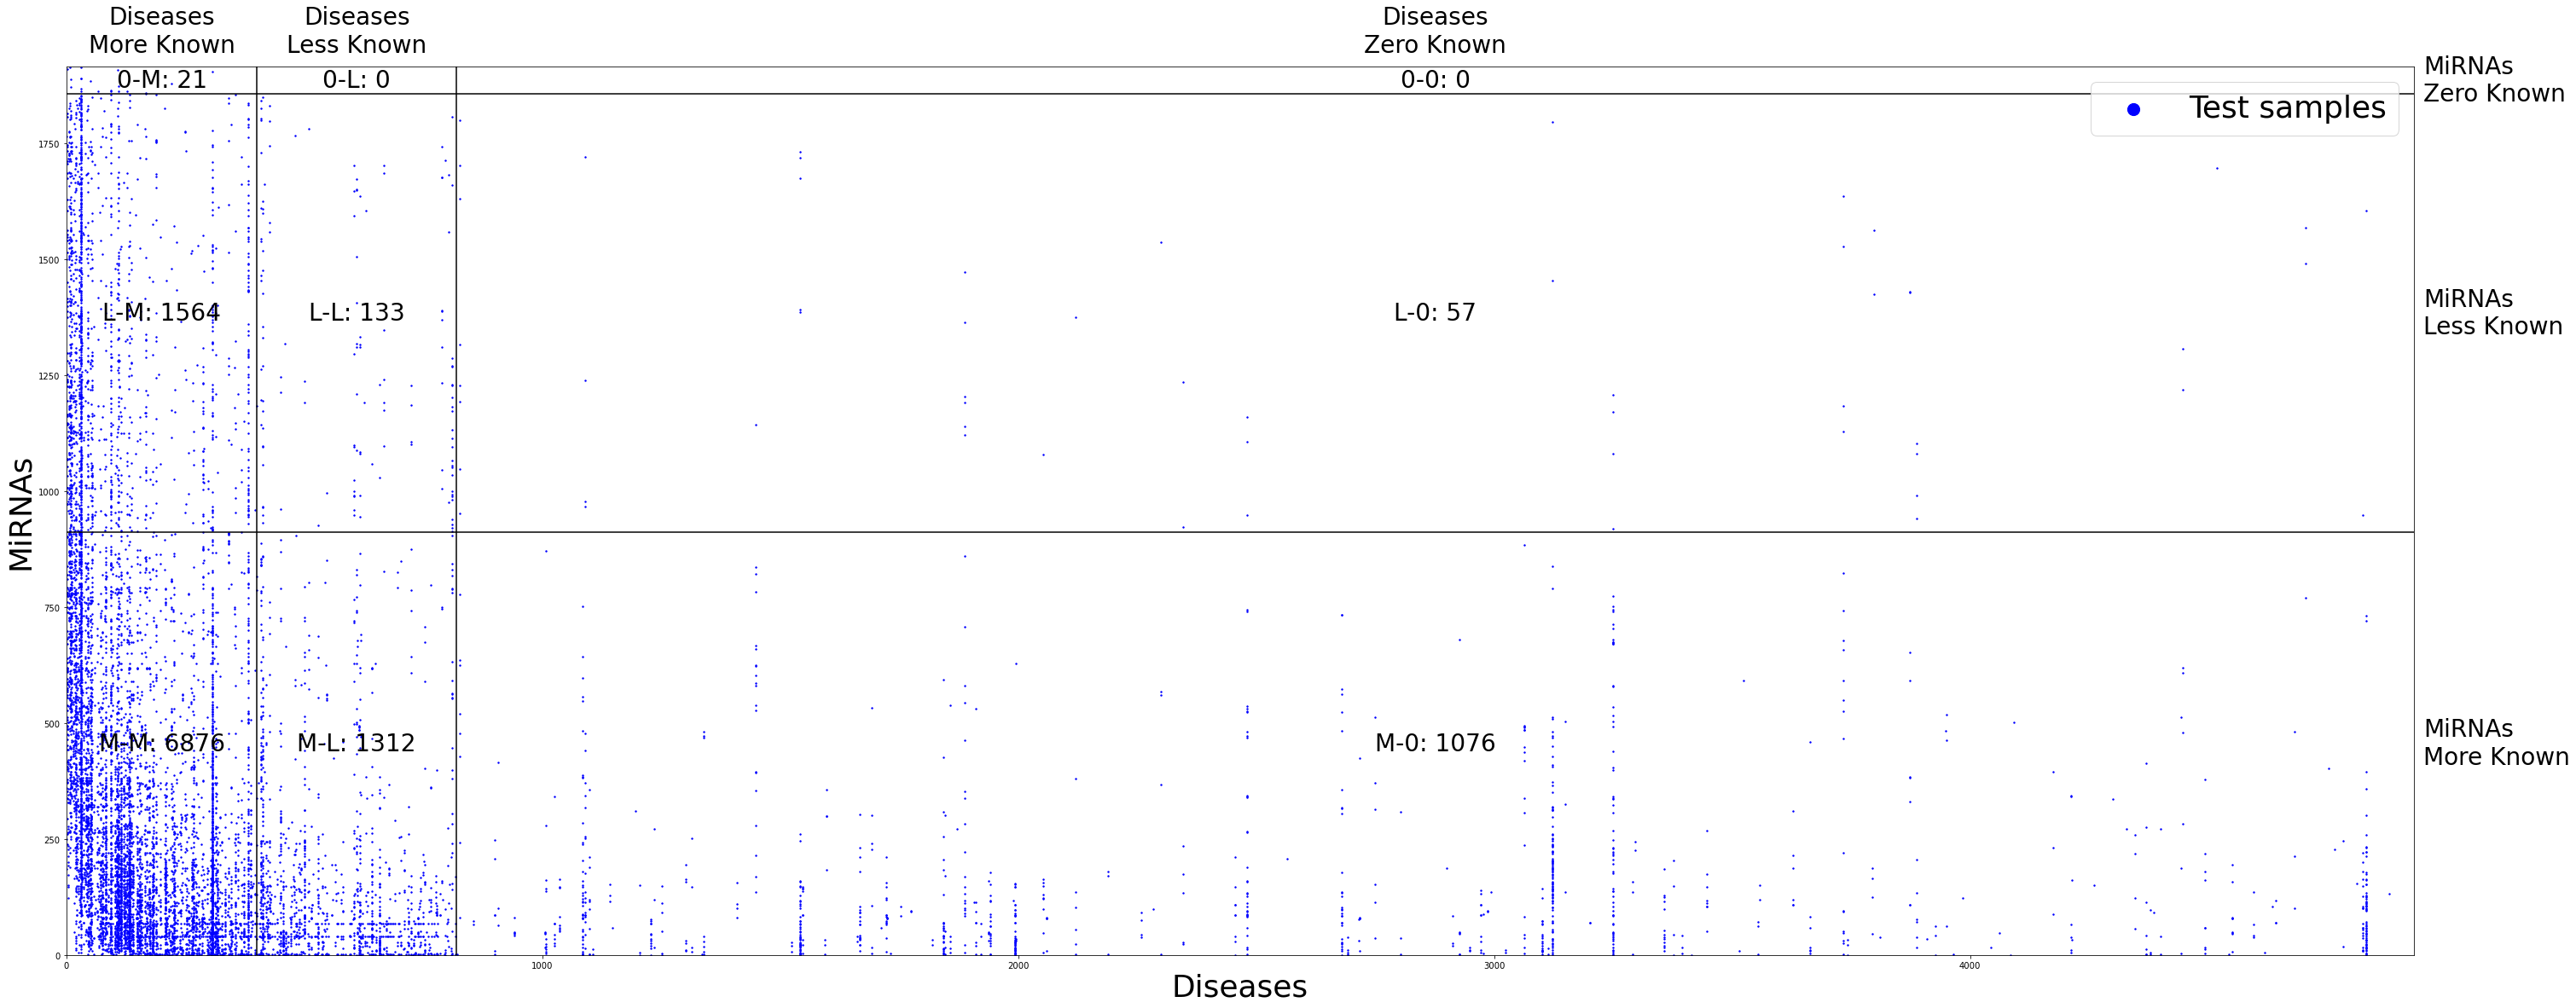

In [17]:
train_posi_samples = train_val_test['train']['posi']
val_posi_samples = train_val_test['val']['posi']
test_posi_samples = train_val_test['test']['posi']
plot_train_val_test(all_posi_samples, train_posi_samples, val_posi_samples, test_posi_samples)

# Graph (NetworkX)

In [2]:
node_list = []

mirnas_df = pd.read_table('our_data/nodes/mirnas.tsv')
assert len(mirnas_df['Accession']) == len(mirnas_df['Accession'].unique())
node_list = node_list + mirnas_df['Accession'].values.tolist()

diseases_df = pd.read_table('our_data/nodes/diseases.tsv')
assert len(diseases_df['ID']) == len(diseases_df['ID'].unique())
node_list = node_list + diseases_df['ID'].values.tolist()

print(len(node_list))

6850


In [3]:
edge_list = []

mirna_mirna_df = pd.read_table('our_data/edges/families_pri_mirna_pri_mirna.tsv').drop_duplicates()
mirna_mirna_df = mirna_mirna_df[(mirna_mirna_df['ID1'].isin(mirnas_df['Accession'])) & (mirna_mirna_df['ID2'].isin(mirnas_df['Accession']))]
edge_list = edge_list + [(edge[0], edge[1]) for edge in mirna_mirna_df.values]

disease_disease_df = pd.read_table('our_data/edges/disease_disease.tsv')[['ID1', 'ID2']].drop_duplicates()
edge_list = edge_list + [(edge[0], edge[1]) for edge in disease_disease_df.values]

print(len(edge_list))

12178


In [4]:
G = nx.Graph()
G.add_nodes_from(node_list)
G.add_edges_from(edge_list)

print(G.number_of_nodes())
print(G.number_of_edges())

6850
12178


In [5]:
# nx.write_adjlist(G, 'our_data/data_without_mrna_and_mid_nx.adjlist')

In [5]:
# mrnas: nodes and edges

node_list = []

mrnas_df = pd.read_table('our_data/nodes/mrnas.tsv')
assert len(mrnas_df['ID']) == len(mrnas_df['ID'].unique())
node_list = node_list + mrnas_df['ID'].values.tolist()

G.add_nodes_from(node_list)

edge_list = []

# There are some circles in mrna-mrna edges, like (ID1 123, ID2 321) and (ID1 321, ID2 123).
# But the networkx graph type Graph(), which is undirected and does not allow parallel edges, it will filter out these circles automatically.
mrna_mrna_df = pd.read_table('our_data/edges/groups_mrna_mrna.tsv').drop_duplicates()
edge_list = edge_list + [(edge[0], edge[1]) for edge in mrna_mrna_df.values]

mirna_mrna_df = pd.read_table('our_data/edges/mirna_mrna_encori_degradome.tsv')[['ID1', 'geneEntrezID']].drop_duplicates()
edge_list = edge_list + [(edge[0], edge[1]) for edge in mirna_mrna_df.values]

mrna_disease_df = pd.read_table('our_data/edges/mrna_disease_disgenet.tsv')[['geneId', 'code']].drop_duplicates()
edge_list = edge_list + [(edge[0], edge[1]) for edge in mrna_disease_df.values]

G.add_edges_from(edge_list)

In [6]:
G.add_nodes_from(node_list)
G.add_edges_from(edge_list)

print(G.number_of_nodes())
print(G.number_of_edges())

26079
1511183


In [8]:
# nx.write_adjlist(G, 'our_data/data_without_mid_nx.adjlist')

# Graph Structure Observation

In [16]:
def get_graph_nx(graph_path, tvt_path):
    
    G = nx.read_adjlist(graph_path)
    
    train_val_test = np.load(tvt_path, allow_pickle=True).item()
    G.add_edges_from(train_val_test['train']['posi'] + train_val_test['val']['posi'] + train_val_test['test']['posi'])
    
    posi_samples = train_val_test['train']['posi'] + train_val_test['val']['posi'] + train_val_test['test']['posi']
    nega_samples = train_val_test['train']['nega'] + train_val_test['val']['nega'] + train_val_test['test']['nega'][:len(train_val_test['test']['posi'])]
    
    return G, posi_samples, nega_samples

In [17]:
def get_node_type(node_id):
    
    if node_id.isdigit():
        return 'mrna'
    elif node_id[:2] == 'MI':
        return 'mirna'
    elif node_id[:1] == 'D':
        return 'disease'
    else:
        print('Wrong ID!')

In [24]:
paths = {
    'graph_without_mid': 'our_data/data_without_mid_nx.adjlist',
    'graph_without_mrna_and_mid': 'our_data/data_without_mrna_and_mid_nx.adjlist',
    'train_val_test': 'our_data/train_val_test_with_sparse.npy'
}

## Shared Neighbors (Jaccard)  

Obviously, miRNA-disease pairs with verified associations have more shared neighbors.  
The design of our method is driven by such an observation.

In [64]:
def get_jaccard_score(a, b):
    
    if (len(a) == 0) & (len(b) == 0):
        return np.nan
    
    return len(a & b) / len(a | b)

In [65]:
def get_neighbor_info(G, shared_type, mi_id, d_id):
    
    mi_neighbors = set()
    d_neighbors = set()
    if shared_type == 'all':
        mi_neighbors = mi_neighbors | set(G.neighbors(mi_id))
        d_neighbors = d_neighbors | set(G.neighbors(d_id))
    else:
        for neighbor in G.neighbors(mi_id):
            if shared_type == 'mrna':
                if get_node_type(neighbor) == 'mrna':
                    mi_neighbors.add(neighbor)
            elif shared_type == 'mirna':
                if get_node_type(neighbor) == 'mirna':
                    mi_neighbors.add(neighbor)
            elif shared_type == 'disease':
                if get_node_type(neighbor) == 'disease':
                    mi_neighbors.add(neighbor)
        for neighbor in G.neighbors(d_id):
            if shared_type == 'mrna':
                if get_node_type(neighbor) == 'mrna':
                    d_neighbors.add(neighbor)
            elif shared_type == 'mirna':
                if get_node_type(neighbor) == 'mirna':
                    d_neighbors.add(neighbor)
            elif shared_type == 'disease':
                if get_node_type(neighbor) == 'disease':
                    d_neighbors.add(neighbor)
    
    return len(mi_neighbors & d_neighbors), get_jaccard_score(mi_neighbors, d_neighbors)

In [66]:
def get_conclusion_df(G, shared_type, samples):
    
    intersection_num, jaccard_score = [], []
    
    for mirna, disease in samples:
        num, score = get_neighbor_info(G, shared_type, mirna, disease)
        intersection_num.append(num)
        jaccard_score.append(score)

    return pd.DataFrame({
        'intersection_num': intersection_num,
        'jaccard_score': jaccard_score
    }, index=samples)

In [67]:
def get_jaccard_distribution(df, partitions):
    
    df_len = len(df)
    distributions = [(df.isna()).sum() / df_len, (df == 0).sum() / df_len, ((df > 0) & (df <= partitions[0])).sum() / df_len]
    
    for i in range(len(partitions) - 1):
        distributions.append(((df > partitions[i]) & (df <= partitions[i + 1])).sum() / df_len)
    
    distributions.append((df > partitions[-1]).sum() / df_len)
    
    return distributions

In [68]:
G, posi_samples, nega_samples = get_graph_nx(paths['graph_without_mid'], paths['train_val_test'])

In [72]:
partitions = [0.1, 0.2]

In [74]:
print('==========')

mirnas_posi = get_conclusion_df(G, 'mirna', posi_samples)
print('MiRNA, Positive:')
display(mirnas_posi.describe())
print('Jaccard Distribution:', [round(i, 5) for i in get_jaccard_distribution(mirnas_posi['jaccard_score'], partitions)])

print('==========')

mirnas_nega = get_conclusion_df(G, 'mirna', nega_samples)
print('MiRNA, Negative:')
display(mirnas_nega.describe())
print('Jaccard Distribution:', [round(i, 5) for i in get_jaccard_distribution(mirnas_nega['jaccard_score'], partitions)])

MiRNA, Positive:


,intersection_num,jaccard_score
count,57298.000000,57298.000000
mean,2.152361,0.012311
std,5.378281,0.039043
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,0.010638
max,69.000000,0.916667


Jaccard Distribution: [0.0, 0.53878, 0.44207, 0.01309, 0.00606]
MiRNA, Negative:


,intersection_num,jaccard_score
count,57298.000000,24803.000000
mean,0.016964,0.000299
std,0.454301,0.004870
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,34.000000,0.333333


Jaccard Distribution: [0.56712, 0.42858, 0.00414, 0.00012, 3e-05]


In [75]:
print('==========')

diseases_posi = get_conclusion_df(G, 'disease', posi_samples)
print('Disease, Positive:')
display(diseases_posi.describe())
print('Jaccard Distribution:', [round(i, 5) for i in get_jaccard_distribution(diseases_posi['jaccard_score'], partitions)])

print('==========')

diseases_nega = get_conclusion_df(G, 'disease', nega_samples)
print('Disease, Negative:')
display(diseases_nega.describe())
print('Jaccard Distribution:', [round(i, 5) for i in get_jaccard_distribution(diseases_nega['jaccard_score'], partitions)])

Disease, Positive:


,intersection_num,jaccard_score
count,57298.000000,57298.000000
mean,0.513910,0.005691
std,0.850763,0.012076
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.007042
max,11.000000,0.250000


Jaccard Distribution: [0.0, 0.63175, 0.36694, 0.00129, 2e-05]
Disease, Negative:


,intersection_num,jaccard_score
count,57298.000000,57298.000000
mean,0.023788,0.000561
std,0.168489,0.006167
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,4.000000,0.333333


Jaccard Distribution: [0.0, 0.97836, 0.02114, 0.0004, 0.0001]


In [73]:
print('==========')

mrnas_posi = get_conclusion_df(G, 'mrna', posi_samples)
print('MRNA, Positive:')
display(mrnas_posi.describe())
print('Jaccard Distribution:', [round(i, 5) for i in get_jaccard_distribution(mrnas_posi['jaccard_score'], partitions)])

print('==========')

mrnas_nega = get_conclusion_df(G, 'mrna', nega_samples)
print('MRNA, Negative:')
display(mrnas_nega.describe())
print('Jaccard Distribution:', [round(i, 5) for i in get_jaccard_distribution(mrnas_nega['jaccard_score'], partitions)])

MRNA, Positive:


,intersection_num,jaccard_score
count,57298.000000,57291.000000
mean,1.247443,0.002650
std,2.711876,0.003911
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.004587
max,99.000000,0.071429


Jaccard Distribution: [0.00012, 0.5566, 0.44328, 0.0, 0.0]
MRNA, Negative:


,intersection_num,jaccard_score
count,57298.000000,56545.000000
mean,0.137631,0.000554
std,0.798740,0.002399
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,42.000000,0.055556


Jaccard Distribution: [0.01314, 0.91604, 0.07082, 0.0, 0.0]


In [76]:
print('==========')

all_posi = get_conclusion_df(G, 'all', posi_samples)
print('All, Positive:')
display(all_posi.describe())
print('Jaccard Distribution:', [round(i, 5) for i in get_jaccard_distribution(all_posi['jaccard_score'], partitions)])

print('==========')

all_nega = get_conclusion_df(G, 'all', nega_samples)
print('All, Negative:')
display(all_nega.describe())
print('Jaccard Distribution:', [round(i, 5) for i in get_jaccard_distribution(all_nega['jaccard_score'], partitions)])

All, Positive:


,intersection_num,jaccard_score
count,57298.000000,57298.000000
mean,3.913714,0.005145
std,6.196202,0.007347
min,0.000000,0.000000
25%,1.000000,0.001046
50%,2.000000,0.003157
75%,5.000000,0.006431
max,99.000000,0.135246


Jaccard Distribution: [0.0, 0.1995, 0.79973, 0.00077, 0.0]
All, Negative:


,intersection_num,jaccard_score
count,57298.000000,57298.000000
mean,0.178383,0.000608
std,0.963564,0.002415
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,49.000000,0.068966


Jaccard Distribution: [0.0, 0.90734, 0.09266, 0.0, 0.0]


## SubGraph Size

For miRNA-disease pairs with verified associations, the surrounding subgraphs are larger.  
This part has not been fully exploited, maybe some subgraph-based link prediction methods can work well.

In [35]:
def get_khop_subgraph(G, k, mi_id, d_id):
    
    subgraph_nodes_before = set()
    subgraph_nodes_after = {mi_id, d_id}
    
    for i in range(k):
        new_nodes = subgraph_nodes_after - subgraph_nodes_before
        subgraph_nodes_before = subgraph_nodes_after
        for node in new_nodes:
            subgraph_nodes_after = subgraph_nodes_after | {neighbor for neighbor in G.neighbors(node)}
    
    return len(subgraph_nodes_after)

In [36]:
# A problem: it's single threading, without parallel computation
def get_subgraph_conclusion_df(G, k, samples):
    
    subgraph_size = []
    
    for mirna, disease in samples:
        num = get_khop_subgraph(G, k, mirna, disease)
        subgraph_size.append(num)

    return pd.DataFrame({
        'subgraph_size': subgraph_size
    }, index=samples)

In [37]:
# parallel computating!
def get_2hop_subgraph_size(adj, adj_2, node_list, samples):
    
    subgraph_size = []
    
    for mirna, disease in samples:
        mi_idx = node_list.index(mirna)
        d_idx = node_list.index(disease)
        neighbor_list = (adj[mi_idx] > 0) | (adj[d_idx] > 0) | (adj_2[mi_idx] > 0) | (adj_2[d_idx] > 0)
        
        # No need to add mi_idx and d_idx, they are already included in adj_2
        # adj_self = np.zeros(adj.shape[0])
        # adj_self[mi_idx] = 1
        # adj_self[d_idx] = 1
        # neighbor_list = (adj[mi_idx] > 0) | (adj[d_idx] > 0) | (adj_2[mi_idx] > 0) | (adj_2[d_idx] > 0) | (adj_self > 0)
        
        subgraph_size.append(neighbor_list.sum())
    
    return subgraph_size

In [38]:
def get_2hop_subgraph_size_df(G, posi_samples, nega_samples):
    
    node_list = list(G.nodes())
    adj = np.mat(nx.to_numpy_array(G))
    adj_2 = np.dot(adj, adj)
    
    return pd.DataFrame({
        'subgraph_size_posi': get_2hop_subgraph_size(adj, adj_2, node_list, posi_samples)
    }, index=posi_samples), pd.DataFrame({
        'subgraph_size_nega': get_2hop_subgraph_size(adj, adj_2, node_list, nega_samples)
    }, index=nega_samples)

In [39]:
G, posi_samples, nega_samples = get_graph_nx(paths['graph_without_mid'], paths['train_val_test'])

In [40]:
subgraph_size_1_posi = get_subgraph_conclusion_df(G, 1, posi_samples)
print('1, Positive:')
display(subgraph_size_1_posi.describe())

subgraph_size_1_nega = get_subgraph_conclusion_df(G, 1, nega_samples)
print('1, Negative:')
display(subgraph_size_1_nega.describe())

1, Positive:


,subgraph_size
count,57298.000000
mean,839.508866
std,609.505186
min,26.000000
25%,393.000000
50%,626.000000
75%,1130.000000
max,3361.000000


1, Negative:


,subgraph_size
count,57298.000000
mean,150.705539
std,148.575366
min,3.000000
25%,67.000000
50%,116.000000
75%,187.000000
max,2962.000000


In [ ]:
# subgraph_size_2_posi = get_subgraph_conclusion_df(G, 2, posi_samples)
subgraph_size_2_posi, subgraph_size_2_nega = get_2hop_subgraph_size_df(G, posi_samples, nega_samples)
print('2, Positive:')
display(subgraph_size_2_posi.describe())
print('2, Negative:')
display(subgraph_size_2_nega.describe())

## Density, Degree, Homophily  

The graph is extremely sparse.  
MiRNAs tend to be heterophile, but diseases and mRNAs tend to be homophile.  
Currently, we use GNN (HGT) layers to treat all meta-relations, and it is doing well so far.  
Maybe the model can be improved by designing customized learning module for each meta-relation, for example, learnable multi-hop meta-paths but not uniformed two hops (layers).

In [42]:
def get_density(G):
    return nx.density(G)

In [43]:
def get_neighbor_type_num(G, node_id):
    
    neighbor_mirna_num = 0
    neighbor_mrna_num = 0
    neighbor_disease_num = 0
    
    for neighbor in G.neighbors(node_id):
        neighbor_node_type = get_node_type(neighbor)
        
        if neighbor_node_type == 'mirna':
            neighbor_mirna_num = neighbor_mirna_num + 1
        elif neighbor_node_type == 'mrna':
            neighbor_mrna_num = neighbor_mrna_num + 1
        elif neighbor_node_type == 'disease':
            neighbor_disease_num = neighbor_disease_num + 1
            
    return neighbor_mirna_num, neighbor_mrna_num, neighbor_disease_num

In [44]:
def get_neighbor_num_df(G):
    
    node_list = list(G.nodes)
    neighbor_mirna = []
    neighbor_mrna = []
    neighbor_disease = []
    
    for node_id in node_list:
        neighbor_mirna_num, neighbor_mrna_num, neighbor_disease_num = get_neighbor_type_num(G, node_id)
        neighbor_mirna.append(neighbor_mirna_num)
        neighbor_mrna.append(neighbor_mrna_num)
        neighbor_disease.append(neighbor_disease_num)
    
    return pd.DataFrame({
        'neighbor_mirna': neighbor_mirna,
        'neighbor_mrna': neighbor_mrna,
        'neighbor_disease': neighbor_disease
    }, index=node_list)

In [45]:
def get_degree_and_homophily(df, column_name):
    
    df['degree'] = df.sum(axis=1).values
    df['homophily'] = (df[column_name] / df['degree']).values
    
    return df

In [46]:
G, posi_samples, nega_samples = get_graph_nx(paths['graph_without_mid'], paths['train_val_test'])

In [47]:
get_density(G)

0.004612581390587416

In [48]:
neighbor_num_df = get_neighbor_num_df(G)

In [49]:
neighbor_mirna_df = neighbor_num_df[neighbor_num_df.index.str.contains('MI')].copy()
neighbor_mirna_df = get_degree_and_homophily(neighbor_mirna_df, 'neighbor_mirna')

display(neighbor_mirna_df)
display(neighbor_mirna_df.describe())

,neighbor_mirna,neighbor_mrna,neighbor_disease,degree,homophily
MI0000060,11,105,197,313,0.035144
MI0000067,11,77,148,236,0.046610
MI0000100,11,86,131,228,0.048246
MI0000434,11,85,142,238,0.046218
MI0000068,11,81,146,238,0.046218
...,...,...,...,...,...
MI0039734,0,0,0,0,NaN
MI0039735,0,0,0,0,NaN
MI0039739,0,0,0,0,NaN
MI0039740,0,0,4,4,0.000000


,neighbor_mirna,neighbor_mrna,neighbor_disease,degree,homophily
count,1917.000000,1917.000000,1917.000000,1917.000000,1875.000000
mean,4.694836,75.449139,29.889411,110.033385,0.039517
std,15.158220,68.122894,46.552878,83.262620,0.124598
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,32.000000,5.000000,51.000000,0.000000
50%,0.000000,58.000000,11.000000,92.000000,0.000000
75%,1.000000,97.000000,30.000000,146.000000,0.009901
max,73.000000,737.000000,433.000000,775.000000,0.890244


In [50]:
neighbor_mrna_df = neighbor_num_df[neighbor_num_df.index.str.isdigit()].copy()
neighbor_mrna_df = get_degree_and_homophily(neighbor_mrna_df, 'neighbor_mrna')

display(neighbor_mrna_df)
display(neighbor_mrna_df.describe())

,neighbor_mirna,neighbor_mrna,neighbor_disease,degree,homophily
9774,44,6,1,51,0.117647
5926,30,14,3,47,0.297872
966,17,453,19,489,0.926380
2218,11,0,67,78,0.000000
573,11,5,7,23,0.217391
...,...,...,...,...,...
124220,0,0,0,0,NaN
201181,0,0,0,0,NaN
118568799,0,0,0,0,NaN
57829,0,3,0,3,1.000000


,neighbor_mirna,neighbor_mrna,neighbor_disease,degree,homophily
count,19229.000000,19229.000000,19229.000000,19229.000000,18371.000000
mean,7.521764,126.846326,7.010505,141.378595,0.576622
std,9.022814,241.028391,16.112838,243.060713,0.400188
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,13.000000,0.114520
50%,5.000000,17.000000,1.000000,34.000000,0.722222
75%,11.000000,108.000000,6.000000,132.000000,0.963176
max,121.000000,1641.000000,388.000000,1677.000000,1.000000


In [51]:
neighbor_disease_df = neighbor_num_df[neighbor_num_df.index.str.contains('D')].copy()
neighbor_disease_df = get_degree_and_homophily(neighbor_disease_df, 'neighbor_disease')

display(neighbor_disease_df)
display(neighbor_disease_df.describe())

,neighbor_mirna,neighbor_mrna,neighbor_disease,degree,homophily
D000006,0,0,1,1,1.000000
D015746,0,223,3,226,0.013274
D000007,0,0,4,4,1.000000
D014947,26,0,53,79,0.670886
D006549,0,0,2,2,1.000000
...,...,...,...,...,...
D064146,0,0,1,1,1.000000
D064807,0,0,1,1,1.000000
D065606,0,0,1,1,1.000000
D065706,0,166,1,167,0.005988


,neighbor_mirna,neighbor_mrna,neighbor_disease,degree,homophily
count,4933.000000,4933.000000,4933.000000,4933.000000,4933.000000
mean,11.615244,27.327184,3.112913,42.055342,0.546628
std,68.004538,96.026080,4.028540,138.091607,0.409855
min,0.000000,0.000000,1.000000,1.000000,0.000917
25%,0.000000,0.000000,1.000000,2.000000,0.111111
50%,0.000000,1.000000,2.000000,5.000000,0.500000
75%,0.000000,14.000000,3.000000,23.000000,1.000000
max,1846.000000,2364.000000,66.000000,2766.000000,1.000000
